# Anomaly Detection
## Overview 

In the recipe, `engine-insights.ipynb`, we demonstrated an introduction to anomaly detection. In this recipe, expand on the methods used in that recipe. Howso Engine can be used to identify anomalous cases in a dataset and also explain why those cases may be anomalous. Furthermore, we can leverage other tools we learned in previous recipes, such  as influential and boundary cases, to provide additional context.

Finding anomalous cases has value in both model building and data exploration. For example, as we continue to build a suitable model for the `Adult` datset, detecting anomalies can give us insight into whether we need to clean the dataset to reduce false signals. Possible sources of anomalies could be cases that are erroneous or falsified.   


# Section 1: Load, Train, Analyze

For questions about the specific steps of this section, please see the [basic workflow guide](https://docs.howso.com/user_guide/basics/basic_workflow.html).


In [1]:
import os

import pandas as pd
import plotly.io as pio
from pmlb import fetch_data

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_anomalies

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

### Step 1: Load Data and Create Trainee

Our example dataset for this recipe continues to be the well known `Adult` dataset. This dataset consists of 14 Context Features and 1 Action Feature. The Action Feature in this version of the `Adult` dataset has been renamed to `target` and it takes the form of a binary indicator for whether a person in the data makes over $50,000/year (*target*=1) or less (*target*=0).

In [2]:
df = fetch_data('adult', local_cache_dir="../../data/adult")

# Subsample the data to ensure the example runs quickly
df = df.sample(1000, random_state=0)

# Infer feature attributes
features = infer_feature_attributes(df)

# Create the Trainee
t = Trainee(features=features)

### Step 2: Train and Analyze

In [3]:
t.train(df)

# Targetless Analysis
t.analyze()

# Section 2: Anomaly Identification

We will use [Familiarity Conviction](https://docs.howso.com/getting_started/terminology.html#familiarity-conviction) and [Distance Contribution](https://docs.howso.com/getting_started/terminology.html#distance-contribution) to identify potentially anomalous cases. Conviction is a value indicating how surprising a case is relative to how surprising other cases in the model are. In the case of `Familiarity Conviction`, the level of surprisal is measured by the perturbation of the probability distribution when the case is added or removed (hence the parameters: `familiarity_conviction_addition` and `familiarity_conviction_removal`).  Howso Engine’s interpretability tools also enable us to understand why these cases may be anomalous and whether they are outliers and inliers. 

### Step 1: Compute Distance Contribution and Familiarity Conviction for every case

The first step is to use `react_into_features` and select the metrics we want to return.

`react_into_features` is a method that calculates the desired attributes for every case in the Trainee and caches those values into each case as a feature.

Notably, this means that these features can then be used as context and action features, but this is only recommended for advanced use-cases.

In [4]:
# Store the familiarity conviction and distance contribution, this will be used to identify anomalous cases
t.react_into_features(
    familiarity_conviction_addition=True,
    distance_contribution=True
)

stored_convictions = t.get_cases(
    session=t.active_session,
    features=df.columns.tolist() + ['familiarity_conviction_addition','.session_training_index', '.session', 'distance_contribution']
)

### Step 2: Set Threshold and Identify Anomalies

There is no absolute threshold for what is considered to be anomalous, as anomalous behavior is a measure of surprisal. Thus, this is a lever that the user can change depending on the data. The threshold should be more or less than 1, which indicates average surprisal.

We first use `familiarity_conviction_addition` to find anomalies, and then use the average `distance_contribution` to determine what type of anomaly the case is (e.g., inlier vs. outlier). Cases with large distance contributions will be considered outliers and those with
low distance contributions will be inliers.

For this data, we use a threshold of 0.75 for the Familiarity Conviction. Cases with a Familarity Conviction below this value will be considered outliers.

In [5]:
# Threshold to determine which cases will be deemed anomalous
convict_threshold = 0.75

# Extract the anomalous cases
low_convicts = stored_convictions[
    stored_convictions['familiarity_conviction_addition'] <= convict_threshold
].sort_values('familiarity_conviction_addition', ascending=True)

# Average distance contribution will be used to determine if a case is an outlier or inlier
average_dist_contribution = low_convicts['distance_contribution'].mean()

# A case with distance contribution greater than average will be tagged as outlier, and vice versa for inliers
cat = [
    'inlier' if d < average_dist_contribution else
    'outlier' for d in low_convicts['distance_contribution']
]
low_convicts['category'] = cat

# Section 3: Anomaly Inspection


### Step 1: Inspect Outliers

Typically, when we think of anomalies, we think of outliers or cases that are significantly different that the rest of the data, whether erroneous or not. Preprocessing in machine learning often involves pruning these data points as they can add undesired noise to a model. 

The Case Feature Residual Conviction will be used to understand why each case was anomalous.

In our example use case where the `Adult` dataset is used to determine projected salary for loan applications, we want to eliminate any erroneous outliers if possible. We may also want to detect substituted values, as often times datasets may substitute special values with nominal integers. For example, blank values in an application are often coded with high integers like 99999 which can introduce noise in the dataset.

### **Definitions:**

**`case_feature_residual_convictions`** :  This is calculated using the local feature residuals, divided by the feature residuals of the Case to obtain the Convictions.

In [6]:
# Extract the outliers cases
outliers = low_convicts[low_convicts['category'] == 'outlier'].reset_index(drop=True)
outliers.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,category
0,54.0,6,269068.0,14,15.0,2,10,0,1,1,99999.0,0.0,50.0,30,0,0.046918,556,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,453.592376,outlier
1,48.0,2,93449.0,14,15.0,2,10,0,1,1,99999.0,0.0,40.0,30,0,0.050178,997,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,443.807391,outlier
2,46.0,5,283004.0,8,11.0,0,4,4,1,0,0.0,0.0,63.0,37,1,0.081274,94,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,383.468683,outlier


### Step 2: Outlier Value Evaluation

From the above results, we can see which cases may be anomalous, however just knowing whether a case is potentially an anomaly doesn't give us all the information we need to make an informed decision. If we are deciding whether to prune a case from our training set, often we only want to prune erroneous values. Even if a case is an anomaly in terms of distance or value, if it is valid we may still leave it in as it represents a legitimate data point. 

By looking at the `Case Feature Residual Convictions`, we can gain some insight as to why a case was deemed anomalous.

In [7]:
# We add a few extra metrics for subsequent examples in this notebook
# Get the case_feature_residual_convictions, influential_cases and boundary_cases
details = {
    'influential_cases': True,
    'case_feature_residual_convictions_robust': True
}

# Specify outlier cases
outliers_indices = outliers[['.session', '.session_training_index']].values

# Residuals must be computed and cached for some of these details
t.react_aggregate(action_feature=".targetless", details = {"feature_residuals_full": True})

# React to get the details of each anomalous case
#   Specify trained cases to react to with 'case_indices'
results = t.react(
    case_indices=outliers_indices,
    preserve_feature_values=df.columns.tolist(),
    leave_case_out=True,
    details=details
)

outlier_case_feature_residual_convictions = pd.DataFrame(
    results['details']['case_feature_residual_convictions_robust']
)[df.columns.tolist()]

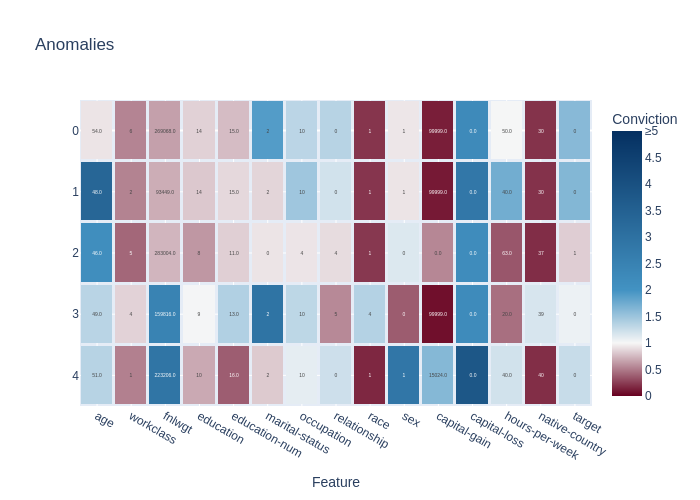

In [8]:
plot_anomalies(outliers, outlier_case_feature_residual_convictions)

From this chart we can see that these cases were flagged as anomalous largely because of their `capital-gain` values. Since our target variable is whether someone makes over $50,000 in salary, people with such large capital gains making less than $50,000 seems odd. In addition, values such as 99999 often indicate some sort of nominal value that may represent something other than the actual capital-gain, such as if a person did not answer. 

With this information, we can choose the appropriate action, whether it is recoding capital-gains, removing the cases, leaving the cases out, etc...

### Step 3: Inspect Outliers

While we generally only think of outliers when it comes to anomalies, inliers are another, more discrete, form of anomaly. Inliers are the opposite of outliers, as inliers are cases that are too [similiar](https://docs.howso.com/getting_started/terminology.html#most-similar-cases) to other points. A real world hypothetical case of an inlier would be someone submitting a false transaction date in which they tried to make the data look real by making it very similar to existing data. 

In our case, it may be someone in a bank who is internally falsifying applications in order to try to alter the prediction model.

Just like outliers, `distance_contribution` is used to detect inliers from the anomalies detected through the use of `familiarity_conviction_addition`, except now we are looking at cases below a theshold which indicates similarity to other points.


In [9]:
# Extract the inlier cases
inliers = low_convicts[low_convicts['category'] == 'inlier'].reset_index(drop=True)
inliers.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,category
0,32.0,4,173449.0,11,9.0,2,6,0,4,1,0.0,0.0,40.0,39,1,0.230027,510,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,132.541928,inlier
1,30.0,4,190228.0,11,9.0,2,6,0,4,1,0.0,0.0,40.0,39,1,0.231294,198,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,132.711366,inlier
2,42.0,4,171351.0,11,9.0,2,6,0,4,1,0.0,0.0,40.0,39,1,0.235698,911,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,133.281169,inlier


### Step 4: Inlier Value Evaluation

In [10]:
# Specify the inlier cases
inliers_indices = inliers[['.session', '.session_training_index']].values

# React to get the details of each case
results = t.react(
    case_indices=inliers_indices,
    preserve_feature_values=df.columns.tolist(),
    leave_case_out=True,
    details=details
)


inlier_case_feature_residual_convictions = pd.DataFrame(
    results['details']['case_feature_residual_convictions_robust']
)[df.columns.tolist()]

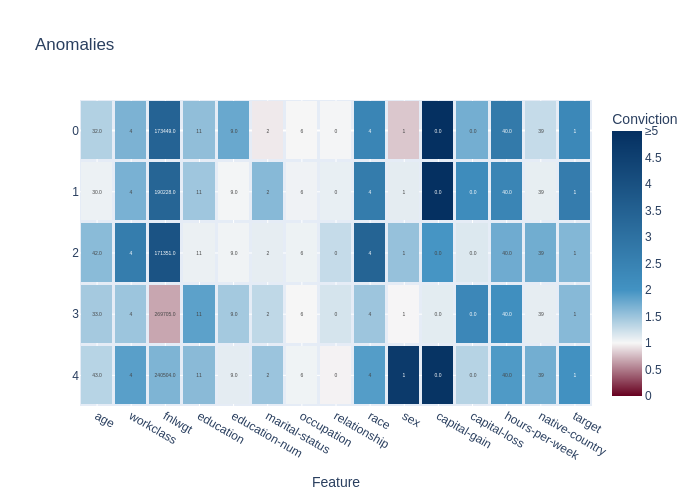

In [11]:
plot_anomalies(inliers, inlier_case_feature_residual_convictions)

This chart is viewed similarly to the outliers chart, however we are now examining cases that are too similar. We can see that for several cases, most features show high `feature_residual_conviction`, indicating that that feature can very easily predicted using the other features. This indicates that all these feature values are unusually predictable compared to the rest of the cases in the model.

# Section 4: Additional Ideas

Here we detail some additional examples methods of diving deeper into the possible anomalies detected above.

In [12]:
# Helper functions

def case_explain_residuals_ratio(anomalous_df, case_feature_residual_convictions, case_ind, num_features=5):
    """Inspect a single case and identify which of its features are particularly anomalous."""
    case = anomalous_df.iloc[case_ind, : ]
    case_num = case['.session_training_index']
    case_df = pd.concat([case, case_feature_residual_convictions.iloc[case_ind, :]], axis=1)
    case_df = case_df.loc[df.columns]
    case_df.columns = ['values', 'case_feature_residual_convictions']
    case_df = case_df.sort_values(['case_feature_residual_convictions'], ascending=True)
    print(f'key features which caused case {case_num} to be anomalous: {case_df.head().index.tolist()}')
    print('')
    display(case_df.head())

def get_cases(anomalous_df, results, case_ind):
    """Inspect a single anomalous case and display its influential and boundary cases."""
    case = anomalous_df.iloc[case_ind, :]
    inf_cases = pd.DataFrame(results['details']['influential_cases'][case_ind])

    print('Original Case:')
    display(case)
    print('')

    print('Influential Cases:')
    display(inf_cases)
    print('')

We can print out a more detailed view of the Outlier Residual Conviction chart shown earlier.

In [13]:
# Print out the explanations for outliers
for i in range(2):
    case_explain_residuals_ratio(
        outliers,
        outlier_case_feature_residual_convictions,
        i
    )
    print('_____________')

key features which caused case 556 to be anomalous: ['capital-gain', 'native-country', 'race', 'workclass', 'fnlwgt']



,values,case_feature_residual_convictions
capital-gain,99999.0,0.122577
native-country,30,0.204752
race,1,0.213440
workclass,6,0.536407
fnlwgt,269068.0,0.648578


_____________
key features which caused case 997 to be anomalous: ['capital-gain', 'native-country', 'race', 'workclass', 'fnlwgt']



,values,case_feature_residual_convictions
capital-gain,99999.0,0.102377
native-country,30,0.202127
race,1,0.215696
workclass,2,0.529495
fnlwgt,93449.0,0.700368


_____________


## Influential cases

[Influential Cases](https://docs.howso.com/getting_started/terminology.html#influential-cases) may also provide additional clues into potentially anomalous data. If a case's influential cases do not well represent itself, then this indicates there are no cases in the model that well represent the anomalous cases.


In [14]:
# Print influential and boundary case outliers
for i in range(2):
    get_cases(outliers, results, i)
    print('_____________')

Original Case:


age                                                                54.0
workclass                                                             6
fnlwgt                                                         269068.0
education                                                            14
education-num                                                      15.0
marital-status                                                        2
occupation                                                           10
relationship                                                          0
race                                                                  1
sex                                                                   1
capital-gain                                                    99999.0
capital-loss                                                        0.0
hours-per-week                                                     50.0
native-country                                                  


Influential Cases:


,race,.session_training_index,age,sex,capital-gain,capital-loss,occupation,hours-per-week,workclass,fnlwgt,education,education-num,.session,relationship,native-country,target,.influence_weight,marital-status
0,4,198,30,1,0,0,6,40,4,190228,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.080426,2
1,4,881,25,1,0,0,6,40,4,218667,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.079445,2
2,4,604,31,1,0,0,6,42,4,96245,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.079267,2
3,4,911,42,1,0,0,6,40,4,171351,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.079230,2
4,4,269,25,1,0,0,6,40,4,236267,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.079077,2
5,4,407,33,1,0,0,6,40,4,269705,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.078788,2
6,4,454,43,1,0,0,6,40,4,240504,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.078107,2
7,4,808,47,1,0,0,6,40,4,209739,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.077619,2
8,4,673,42,1,0,0,6,40,4,53956,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.076765,2
9,4,406,32,1,0,0,14,40,4,154087,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.072934,2



_____________
Original Case:


age                                                                48.0
workclass                                                             2
fnlwgt                                                          93449.0
education                                                            14
education-num                                                      15.0
marital-status                                                        2
occupation                                                           10
relationship                                                          0
race                                                                  1
sex                                                                   1
capital-gain                                                    99999.0
capital-loss                                                        0.0
hours-per-week                                                     40.0
native-country                                                  


Influential Cases:


,race,.session_training_index,age,sex,capital-gain,capital-loss,occupation,hours-per-week,workclass,fnlwgt,education,education-num,.session,relationship,native-country,target,.influence_weight,marital-status
0,4,510,32,1,0,0,6,40,4,173449,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.080529,2
1,4,881,25,1,0,0,6,40,4,218667,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.080121,2
2,4,269,25,1,0,0,6,40,4,236267,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.079852,2
3,4,407,33,1,0,0,6,40,4,269705,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.079282,2
4,4,604,31,1,0,0,6,42,4,96245,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.078870,2
5,4,911,42,1,0,0,6,40,4,171351,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.078753,2
6,4,454,43,1,0,0,6,40,4,240504,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.078051,2
7,4,808,47,1,0,0,6,40,4,209739,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.077305,2
8,4,673,42,1,0,0,6,40,4,53956,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.075793,2
9,4,591,29,1,0,0,14,40,4,178551,11,9,27d9de6c-5dc5-43b6-ac7b-a5818fb992b1,0,39,1,0.073059,2



_____________
